All the imports needed for the running of the script, Updated as the experemnt goes 

In [20]:
import pandas as pd 
import numpy as np 
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
from datetime import datetime, timedelta
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
warnings.filterwarnings('ignore')
import progressbar
import tensorflow as ts
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,models
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.linear_model import LogisticRegression
from random import random

Data preprocessing. This converts a timestamp in the format %M:%S%S.%f%f Where 
- %M is Minutes with no padded zeros 
- %S is Seconds with zeros padded to the left
- %f is Milliseconds with no padded zeros 

To milliseconds. 

In [4]:
def memory_gbts(unit) : 
    local_unit = 0.0
    if unit.endswith("K"):
        local_unit = float(unit[:-1])/1e9
    elif unit.endswith("M"): 
        local_unit = float(unit[:-1])/1e6
    elif unit.endswith("G") : 
        local_unit = float(unit[:-1])/1e3
    else : 
        local_unit = float(unit)/1e12
    return local_unit

In [22]:
def memory_converter(memory) :
    memory_over_terabyte = []
    for unit in memory :
        local_unit = memory_gbts(unit)
            #print(unit)
        memory_over_terabyte.append(local_unit)
    return memory_over_terabyte

In [5]:
def time_converter(timestamp):
    broken_time = timestamp.split(".")
    milliseconds = float("0." + broken_time[-1]) * 1000
    borken_farther = broken_time[0].split(":")
    seconds = int(borken_farther[-1])
    minutes = int(borken_farther[0])
    total_seconds = seconds + minutes*60
    total_milliseconds = milliseconds + total_seconds*1000
    return total_milliseconds

This function extracts the time at which the file was logged from the file name and returns it as a timestamp 

In [6]:
def get_timestamp(filename) : 
    timestamp = filename[8:-4].replace('_',':')
    return timestamp

The following cell defines the column names for the read text files for when they are converted to a data frame

In [7]:
column_names = ["Process ID","User","PR","NI","VIRT","RES","SHR","S","[%CPU]","[%MEM]","TIME+","Args","Timestamp","Benign"]

This method takes the full path to a file, the file name and a list in which it will store the data, as well as a flag that indicates if this file corrospond to benign or melign run

In [8]:
def read_file(filename,safe_filename,all_data, benign = 1) :
    # Reads a text file with columns seperated by tabs and stores it in a data frame object
    df = pd.read_csv(filename, delimiter = "\t", skiprows = [0,1,2,3,4,5,-1])
    # Stores the data contained in the data frame object in an array 
    data = df.iloc[:,0].values
    i = 0
    # Loop through all the data points 
    for d in data[:-1] :
        try :
            row = []
            # The variable d at this point is a whole line, with some awckward spacing between the different 
            # variables, so here all spaces are removed by the split method, then are rejoined with a single 
            # space beteween them by the use of the join method
            d = " ".join(d.split())
            # Storing all the data up to the 12th element in row, the 12th and beyond element needs further processing 
            row = d.split(" ")[:11]
            # Storing all the elements including and beyond the 12th element. They are saved all as a single variable
            # this variable is the API caller. 
            row.append(d.split(" ")[11:])
            # converting the PID (process ID) column to Integer
            row[0] = int(row[0])
            # Convert the memory information to numarical values 
            row[4:7] = memory_converter(row[4:7])
            row[9] = float(row[9])
            row[8] = float(row[8])
            # Convert timestamps into millisecond values 
            row[10] = time_converter(row[10])
            # Collect the sampling time from the filename 
            row.append(get_timestamp(safe_filename))
            # Indicate whether this row corrospond to a benign or a melign run 
            row.append(benign)
            # The row is done being processed and is stored 
            all_data.append(row)
            i += 1
        # For lines which might contain contaminated or corrupt data or data in different format
        except ValueError : 
            #print(safe_filename, " In the line " , i)
            #print(d)
            continue
    return all_data

This function will go through all files in any given directory and count how many are there. This is only used for updating the progressbar and is not nessesary for understanding the training process

In [9]:
def get_files_count(root,counter = 0):
    counter += 1
    for root, dirs, files in os.walk(root, topdown=True):
        for name in files:
            if name.endswith(".txt") : 
                counter += 1
        for name in dirs:
            new_path = os.path.join(root, name)
            counter = get_files_count(new_path,counter)
    return counter 

Those are variables and functions that are used to keep track of how many files have been run already to update the progress bar as well as other progress bar functionalities, start,update and finish

In [10]:
file_count = get_files_count(".")
counter = 0
bar = progressbar.ProgressBar(maxval=100, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [11]:
def progressbar_ignite():
    global counter,bar
    counter = 0
    bar.start()

In [12]:
def progressbar_stop():
    global bar
    bar.update(100)
    bar.finish()

In [13]:
def update_progressbar(counter) : 
    global file_count,bar
    percent_done = counter/float(file_count)
    percent = int(percent_done*100)
    bar.update(percent)

This is a function that will make use of the previous [read_file] function to read all files in a given directory and pass on appropriate parameters to [read_file] function. This function will return a list that contains all the rows read from each of the files 

In [14]:
def reading_files(root,benign) :
    global counter,all_data
    # Updating the progressbar everytime this function is called, this is a recursive function so it will be called
    # Multiple times 
    update_progressbar(counter)
    # Using the walk method which returns the root of the directory we are accessing, the child directories and 
    # the child files. Those are stored in root, dirs and files respectively
    for root, dirs, files in os.walk(root, topdown=True):
        # Looping through all the child files 
        for name in files:
            # Checking if they are text files, if so, then we are going to read them and store the values they have
            if name.endswith(".txt") : 
                
                file_path = os.path.join(root, name)
                # Reading the file's contents and storing it in the list
                all_data = read_file(file_path,name,all_data,benign=benign)
                # We read one more file :) . (for the progressbar) 
                counter += 1
        # For each of the child directories we will check         
        for name in dirs:
            # If the directory name is Benign then all the following directories and files will be Benign files 
            # So we update the benign variable to 1 in the recursive call 
            new_path = os.path.join(root, name)
            if name == "Benign" :
                reading_files(new_path,1)
            # If the directory name is Malign then all the directories we will acess next and files will represent 
            # Malign data, so the benign variable is updated to 0. 
            elif name == "Malign" :
                reading_files(new_path,0)
            # If its neither, then this means we are accessing a folder within those previous two, it will contain 
            # data of the kind its parent directory have passed to it, 0 for Malign and 1 for benign 
            else : 
                reading_files(new_path,benign)

Few cells for nicely presented output

In [15]:
def nice_graph_init(ylabel = "process count", xlabel = "Probability", title = r"Likelyhood of a process being benign",figsize = (8,6)): 
    plt.style.use('dark_background')
    figure = plt.figure(figsize = figsize)
    figure.subplots_adjust(bottom = 0.22)
    ax = figure.add_subplot(111)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set_title(title, fontsize = 16, fontfamily = "monospace")
    ax.set_ylabel(ylabel, fontsize = 14, fontfamily = "monospace")
    ax.set_xlabel(xlabel, fontsize = 14, fontfamily = "monospace")
    ax.minorticks_on()
    return ax,figure

In [76]:
def nice_graph_finish(figure,ax,filename = "plotFinal.png"):
    ax.xaxis.set_tick_params(length = 5, width = 1)
    ax.yaxis.set_tick_params(length = 5, width = 1)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

This cell makes sure the data is in the correct format

In [17]:
def turn_to_X(df) :
    X = df.values
    X = np.asarray(X).astype('float32')
    return X

Takes one file and plots the probability distribution of the processes is contain. If its a Malign file its distribusion is gonna be plotted in magenta, if its benign it will be plotted in turquoise instead. For the test experiment 

In [74]:
def plot_one_file(file_path,safe_filename,benign):
    single_file = []
    # Gets all the data from a file in an list 
    single_file = read_file(file_path,safe_filename,single_file,benign)
    # Turns the list into a data frame with appropriate column names. 
    single_file_df = pd.DataFrame(single_file,columns = column_names)
    # Gets rid of columns that we have no use of 
    X_single_file = single_file_df.drop(["Process ID","User","PR","NI","S","Args","Timestamp","Benign"],axis =1,inplace=False)
    # Changing the input array into appropriate type 
    X_single_file = turn_to_X(X_single_file)
    # Generating the probabilities out of the input array using the already trained DNN 
    Y_single_file = DNN.predict(X_single_file)
    # Ordering the probabilities in ascending order for clearere visualisation. 
    Y_single_file = np.sort(Y_single_file[:,0])
    # Generating an x array of the same dimensions for plotting purposses 
    x = np.arange(Y_single_file.shape[0])
    # Colors for distinguishing the data being plotted 
    color = ["red","white"]
    alpha = [0.8,0.2]
    # plotting, this function is gonna be called for each of the files, so the plots will stack on top of each other
    plt.plot(x,Y_single_file,color = color[benign==1], alpha = alpha[benign==1])

In [63]:
def plot_all_files(root,benign) :
    global counter
    # For more insight on how this function works revise the function reading_files
    update_progressbar(counter)
    for root, dirs, files in os.walk(root, topdown=True):
        for name in files:
            if name.endswith(".txt") : 
                file_path = os.path.join(root, name)
                if(random() > 0.95) :
                    plot_one_file(file_path,name,benign)
                counter += 1
        for name in dirs:
            #print(name)
            new_path = os.path.join(root, name)
            if name == "Benign" :
                plot_all_files(new_path,1)
            elif name == "Malign" :
                plot_all_files(new_path,0)
            else : 
                plot_all_files(new_path,benign)  

# Experiment I

### reading the data 

In [23]:
all_data = []
progressbar_ignite()
reading_files(os.curdir,1)
progressbar_stop()

[=========================================================================] 100%


In [50]:
formatted_df = pd.DataFrame(all_data,columns = column_names)
DNN_Y = formatted_df["Benign"].values
DNN_X = formatted_df.drop(["Process ID","User","PR","NI","S","Args","Timestamp","Benign"],axis =1,inplace=False)
DNN_X = DNN_X.values
DNN_X_Train,DNN_X_Test,DNN_Y_Train,DNN_Y_Test = train_test_split(DNN_X,DNN_Y,test_size = 0.2, random_state = 13)

### Training hyperparameters 

In [51]:
epoches = 50
batch_size = 4098*2
verbos = 2
X = DNN_X_Train
Y = DNN_Y_Train.reshape(-1,1)
X = np.asarray(X).astype('float32')

### Model 

In [66]:
DNN = models.Sequential([layers.Dense(128,activation="relu",input_shape=(6,)),
                         layers.Dense(64,activation="relu"),
                         layers.Dense(32,activation="relu"),
                         layers.Dense(16,activation="relu"),
                         layers.Dense(1,activation="sigmoid")
])
DNN.compile(optimizer = "Adam" , loss = "MeanSquaredError", metrics = "accuracy")
DNN.fit(
    x=X, y=Y, batch_size=batch_size, epochs=epoches, verbose=verbos,
    validation_split=0.2
)

Epoch 1/50
1401/1401 - 19s - loss: 0.3606 - accuracy: 0.5016 - val_loss: 0.3727 - val_accuracy: 0.5081
Epoch 2/50
1401/1401 - 19s - loss: 0.3546 - accuracy: 0.5022 - val_loss: 0.3081 - val_accuracy: 0.5013
Epoch 3/50
1401/1401 - 19s - loss: 0.3206 - accuracy: 0.5032 - val_loss: 0.3519 - val_accuracy: 0.4990
Epoch 4/50
1401/1401 - 18s - loss: 0.3076 - accuracy: 0.5032 - val_loss: 0.2687 - val_accuracy: 0.5081
Epoch 5/50
1401/1401 - 18s - loss: 0.2687 - accuracy: 0.5049 - val_loss: 0.2509 - val_accuracy: 0.5070
Epoch 6/50
1401/1401 - 18s - loss: 0.2507 - accuracy: 0.5070 - val_loss: 0.2499 - val_accuracy: 0.5081
Epoch 7/50
1401/1401 - 18s - loss: 0.2499 - accuracy: 0.5080 - val_loss: 0.2499 - val_accuracy: 0.5081
Epoch 8/50
1401/1401 - 18s - loss: 0.2499 - accuracy: 0.5080 - val_loss: 0.2499 - val_accuracy: 0.5080
Epoch 9/50
1401/1401 - 19s - loss: 0.2499 - accuracy: 0.5080 - val_loss: 0.2499 - val_accuracy: 0.5081
Epoch 10/50
1401/1401 - 18s - loss: 0.2499 - accuracy: 0.5079 - val_loss:

### Evaluation on test set 

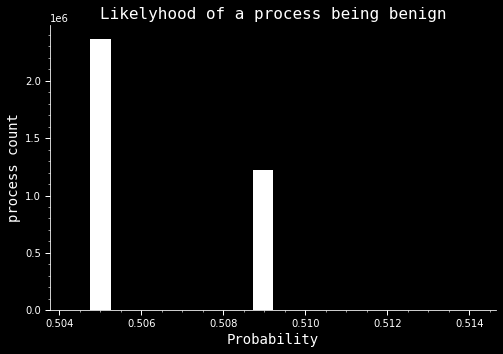

In [67]:
DNN_X_Test = np.asarray(DNN_X_Test).astype('float32')
DNN_Y_Test = DNN_Y_Test.reshape(-1,1)
Y_PRED = DNN.predict(DNN_X_Test)
ax, fig = nice_graph_init()
plt.hist(Y_PRED,bins = 20,color = "white")
nice_graph_finish(fig,ax)


In [69]:
Y_pred = np.where(Y_PRED > 0.508, 1, 0)
cm = confusion_matrix(Y_pred,DNN_Y_Test)
print(cm)


[[1167628 1197913]
 [ 597828  622838]]


# Eperiment II

### Reading the data 

In [70]:
path = os.path.join("Benign","")
path = os.path.join(path,"10minidle/top_logs")
all_files = os.listdir(path)

In [71]:
single_file = []
full_path = os.path.join(path,all_files[0])
single_file = read_file(full_path,all_files[0],single_file,1)
single_file_df = pd.DataFrame(single_file,columns = column_names)
X_single_file = single_file_df.drop(["Process ID","User","PR","NI","S","Args","Timestamp","Benign"],axis =1,inplace=False)
X_single_file = turn_to_X(X_single_file)
Y_single_file = DNN.predict(X_single_file)

### Visualise for a single file (Illustration)

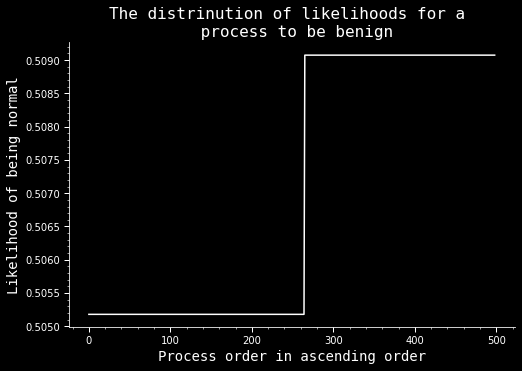

In [72]:
Y_single_file = np.sort(Y_single_file[:,0])
ax, fig = nice_graph_init(xlabel = "Process order in ascending order" , ylabel = "Likelihood of being normal",
                          title = "The distrinution of likelihoods for a \n process to be benign")
plt.plot(Y_single_file,color = "white")
nice_graph_finish(fig,ax,filename = "expII.png")

### Visualising for all files (Will take a while) 

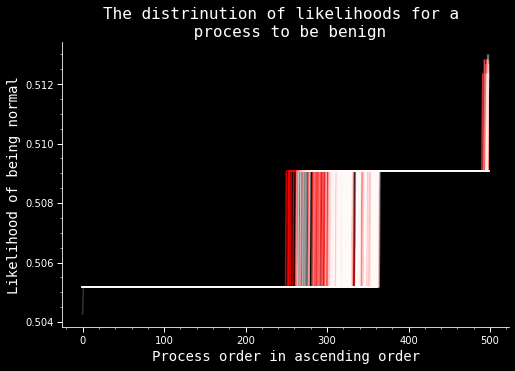

In [75]:
progressbar_ignite()
ax, fig = nice_graph_init(xlabel = "Process order in ascending order" , ylabel = "Likelihood of being normal",
                          title = "The distrinution of likelihoods for a \n process to be benign")
plot_all_files(".",1)
nice_graph_finish(fig,ax,filename = "expIIResultsFinal.png")
progressbar_stop()

# Both Experiments Done